## Import Statements

In [1]:
import os
import random
import numpy as np
from numpy import where
import pandas as pd
import matplotlib.pyplot as plt

os.environ["CDF_LIB"] = "/usr/local/lib/cdf/lib/"
import netCDF4 as nc
from spacepy import pycdf
from pyspedas import wind

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from sklearn.svm import OneClassSVM

2022-06-14 11:04:30.622168: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-14 11:04:30.625054: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-14 11:04:30.625066: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Various functions

In [2]:
# Constants
e = 1.602176634e-19
m = 9.109383701528e-31
e_0 = 8.854187812813e-12
cons = e/((m*e_0)**.5)/(2*np.pi)

In [3]:
def find_closest_time(time, lst):
    return min(range(len(lst)), 
               key=lambda i: abs(time-lst[i]))

def conv_dens_to_freq(ne):
    assert ne>=0
    return ne**.5 * cons

def norm(lst, max_val):
    return np.array([val/max_val for val in lst])

def denorm(lst, max_val):
    return np.array([val*max_val for val in lst])

## Building Model

model = Sequential()
model.add(Conv1D(8, kernel_size=2, activation='relu', input_shape=(96, 1)))
model.add(MaxPool1D(4))
model.add(Conv1D(16, kernel_size=4, activation='relu'))
model.add(MaxPool1D(4))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

In [4]:
model = Sequential()
model.add(Conv1D(8, kernel_size=3, activation='relu', input_shape=(96, 1)))
model.add(Conv1D(16, kernel_size=3, activation='relu'))
model.add(MaxPool1D(4))
model.add(Conv1D(32, kernel_size=3, activation='relu'))
model.add(MaxPool1D(4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 94, 8)             32        
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 16)            400       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 23, 16)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 21, 32)            1568      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 32)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 160)               0

2022-06-14 11:04:31.369645: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-14 11:04:31.369660: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-14 11:04:31.369671: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ayu): /proc/driver/nvidia/version does not exist
2022-06-14 11:04:31.369826: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Importing Data

In [5]:
with nc.Dataset("data/wi_wav_tnr_19950625.nc") as file:
    time = file["tnr_ch1_time"][:]
    freq = file["tnr_ch1_freq"][:]
    spec = file["tnr_ch1_spec"][:]
print(len(time), time[0])

19419 804038402.049


In [6]:
with nc.Dataset("../software/00558/nn_1995_06_25.nc") as file:
    time2 = file["Time"][:]
    raw_fpe = file["Plasma Frequency"][:]
    #ne = file["Electron Density"][:]
time2 = [t+804038400 for t in time2[:]]
print(len(time2), time2[0])

19412 804038402.7850001


In [7]:
index_from_closest_time = list(map(lambda t: find_closest_time(t, time2), time))

In [8]:
fpe = list(map(lambda i: raw_fpe[i], index_from_closest_time))

In [9]:
print(np.shape(time), np.shape(np.transpose(spec)), np.shape(fpe))
data_v1 = [[time[i], np.transpose(spec)[i], fpe[i]] for i in range(len(fpe))]

(19419,) (19419, 96) (19419,)


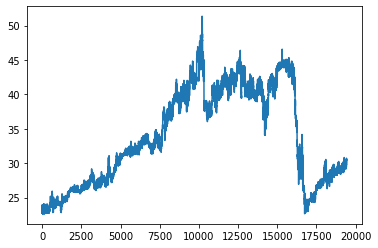

In [10]:
plt.plot(fpe)
# Noticed there were a ton of outliers and messy data, so I decided to remove them from the dataset

In [11]:
random.seed(10)
random_index = list(range(len(data_v1)))
random.shuffle(random_index)
data_v3 = list(map(lambda i: data_v1[i], random_index))

In [12]:
# Check to see if the data repeats - not needed to run code

#for i in range(len(data_v3)):
#    for j in range(len(data_v3)):
#        if not i == j:
#            if data_v3[i][0] == data_v3[j][0]:
#                print(i, j)

In [13]:
x_data = np.array([d[1] for d in data_v3])
y_data = np.array([d[2] for d in data_v3])

norm_y = norm(y_data,max(y_data))

s = len(y_data)*9//10
train_x_data, test_x_data = x_data[:s], x_data[s:]
train_y_data, test_y_data = norm_y[:s], norm_y[s:]
test_sorted = data_v3[s:]

test_sorted.sort(key=lambda x: x[0])
test_time_sorted = np.array([d[0] for d in test_sorted])
test_x_sorted = np.array([d[1] for d in test_sorted])
test_y_sorted = np.array([d[2]/max(y_data) for d in test_sorted])

## Training algorithm

In [14]:
model.compile(loss = keras.losses.mean_squared_error, 
   optimizer = keras.optimizers.Adam(), metrics = ['MeanAbsolutePercentageError'])

In [15]:
#model.fit(
#    x=train_x_data, y=train_y_data, epochs=1000, batch_size=5, steps_per_epoch=20,
#    validation_split=0.05, workers=5, use_multiprocessing=True)
model.fit(
    x=train_x_data, y=train_y_data, epochs=100, batch_size=32, steps_per_epoch=500, shuffle=True,
    validation_split=.05, workers=10, use_multiprocessing=True)

Epoch 1/100
500/500 [==============================] - 1s 2ms/step - loss: 0.0129 - mean_absolute_percentage_error: 8.1149 - val_loss: 9.2414e-04 - val_mean_absolute_percentage_error: 2.8548
Epoch 2/100
500/500 [==============================] - 1s 1ms/step - loss: 5.3416e-04 - mean_absolute_percentage_error: 2.2084 - val_loss: 3.4070e-04 - val_mean_absolute_percentage_error: 1.5009
Epoch 3/100
500/500 [==============================] - 1s 1ms/step - loss: 8.6243e-04 - mean_absolute_percentage_error: 2.2605 - val_loss: 2.1673e-04 - val_mean_absolute_percentage_error: 1.6247
Epoch 4/100
500/500 [==============================] - 1s 1ms/step - loss: 2.9979e-04 - mean_absolute_percentage_error: 1.5629 - val_loss: 1.4724e-04 - val_mean_absolute_percentage_error: 1.2317
Epoch 5/100
500/500 [==============================] - 1s 1ms/step - loss: 1.5628e-04 - mean_absolute_percentage_error: 1.3042 - val_loss: 1.2182e-04 - val_mean_absolute_percentage_error: 1.1594
Epoch 6/100
500/500 [========

In [16]:
model.evaluate(test_x_data, test_y_data)

61/61 [==============================] - 0s 942us/step - loss: 9.3095e-06 - mean_absolute_percentage_error: 0.3601


[9.309479537478182e-06, 0.36007803678512573]

61/61 [==============================] - 0s 699us/step


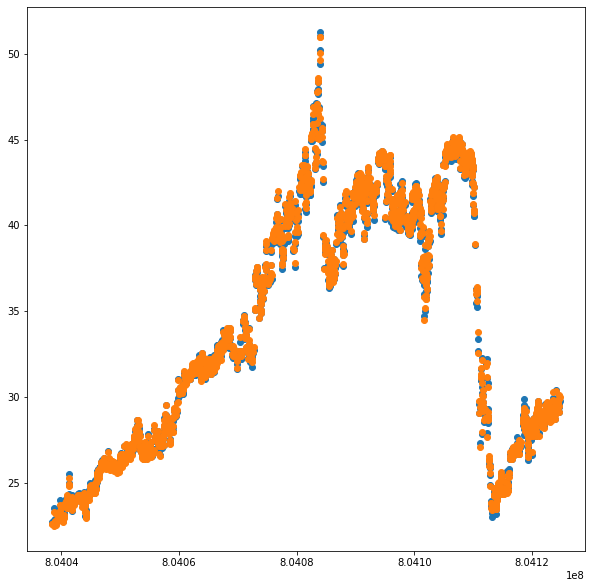

In [17]:
pred_y = model.predict(test_x_sorted)
plt.figure(figsize=(10,10))
plt.scatter(test_time_sorted, denorm(test_y_sorted, max(y_data)))
plt.scatter(test_time_sorted, denorm(pred_y, max(y_data)))

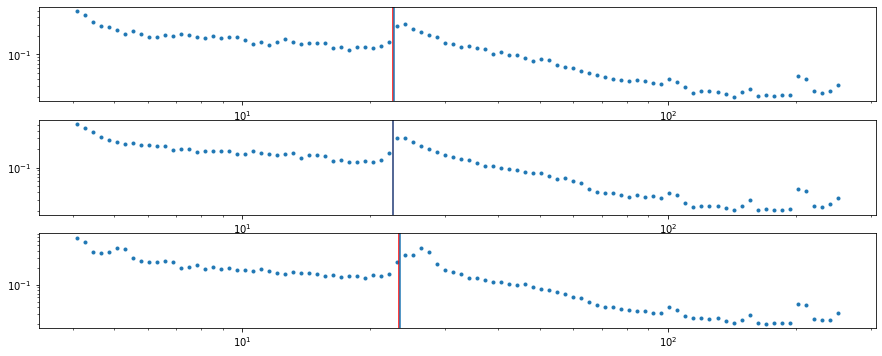

In [18]:
point = 100
n = 4
peakshift = (1 + 8*(1/7.3916)**2)
plt.figure(figsize=(15, 2*n))
for i in range(1, n):
    plt.subplot(n,1, i)
    plt.plot(freq/1000, test_x_sorted[i], 'o', markersize=3, label='WIND data')
    f = freq[max(range(len(freq)), key=lambda x: test_x_sorted[i][x] if freq[x]/1000>10 else 0)]/1000

    plt.axvline(x=denorm(pred_y, max(y_data))[i], color='r')
    plt.axvline(x=denorm(test_y_sorted, max(y_data))[i])
    plt.xscale('log')
    plt.yscale('log')
#print(pred_y[point], test_y_sorted[point])
#print(pred_y[point]*max(y_data), test_y_sorted[point]*max(y_data))
#max(pred_y)
plt.show()

In [19]:
lst = []
for i in range(len(pred_y)):
    lst.append(abs(pred_y[i]-test_y_sorted[i])/test_y_sorted[i])
pd.DataFrame(lst).describe()

,0
count,1942.000000
mean,0.003601
std,0.002967
min,0.000006
25%,0.001408
50%,0.003033
75%,0.005099
max,0.029552


In [20]:
pd.DataFrame([n*max(y_data) for n in test_y_sorted]).describe()

,0
count,1942.000000
mean,33.943680
std,7.086608
min,22.663044
25%,27.152046
50%,32.550470
75%,40.874681
max,51.269535


In [21]:
index = max(range(len(pred_y)), key=lambda i:abs(pred_y[i]-test_y_sorted[i]))
print(test_y_sorted[index]*max(y_data), (pred_y[index]-test_y_sorted[index])*max(y_data))

40.487617 [1.1964937]


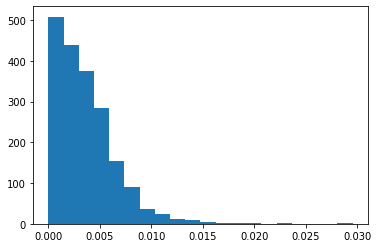

In [22]:
plt.figure(facecolor='w')
plt.hist([v[0] for v in lst], bins=20)
plt.savefig("plots/file.png")

In [23]:
pd.DataFrame(lst).describe()

,0
count,1942.000000
mean,0.003601
std,0.002967
min,0.000006
25%,0.001408
50%,0.003033
75%,0.005099
max,0.029552


In [24]:
pd.DataFrame(test_y_sorted).describe()

,0
count,1942.000000
mean,0.661018
std,0.138004
min,0.441339
25%,0.528758
50%,0.633886
75%,0.795992
max,0.998421


In [25]:
43/720

0.059722222222222225

In [26]:
val_den = []

for y in y_data:
    if not y in val_den:
        val_den.append(y)
val_den.sort()
print(val_den, len(y_data))
print(np.divide([val_den[i]-val_den[i-1] for i in range(1,len(val_den))], val_den[:-1]))

[22.618572, 22.62824, 22.64015, 22.641108, 22.644663, 22.645372, 22.649416, 22.655884, 22.660332, 22.660557, 22.663044, 22.666378, 22.669262, 22.672918, 22.678135, 22.679739, 22.68003, 22.68201, 22.682154, 22.682175, 22.683037, 22.683937, 22.68818, 22.689861, 22.69103, 22.691332, 22.691511, 22.693281, 22.693895, 22.694496, 22.694675, 22.696875, 22.696987, 22.697166, 22.698877, 22.70091, 22.701862, 22.703785, 22.706095, 22.70611, 22.706532, 22.707207, 22.707642, 22.709352, 22.709728, 22.710163, 22.712093, 22.71216, 22.714712, 22.714727, 22.716349, 22.716988, 22.717054, 22.718151, 22.718287, 22.719639, 22.722132, 22.723408, 22.72398, 22.724264, 22.72485, 22.724903, 22.725422, 22.725946, 22.725977, 22.727652, 22.72778, 22.72781, 22.729485, 22.730581, 22.730906, 22.732077, 22.733137, 22.733204, 22.733429, 22.733677, 22.734316, 22.734428, 22.735428, 22.73561, 22.736044, 22.736315, 22.73633, 22.736788, 22.737299, 22.73863, 22.74078, 22.740788, 22.744236, 22.744267, 22.746311, 22.746372, 22.7

In [27]:
np.mean(pred_y)

0.661979